In [84]:
import pandas as pd
import matplotlib.pyplot as plt

In [227]:
df = pd.read_csv('Charging details report October 10, 2014 - October 21, 2022.csv', delimiter=';')

In [228]:
df.head()

,ChargeStartDateTime,Model,Country,SiteLocationName,Description,QuantityBase,QuantityTier1,QuantityTier2,QuantityTier3,QuantityTier4,...,UnitCostBase,UnitCostTier1,UnitCostTier2,UnitCostTier3,UnitCostTier4,VAT,Total Exc. VAT,Total Inc. VAT,Status,Invoice
0,2022-10-21T08:45:10+02:00,ms,PL,"Krakow, Poland",CHARGING : NO_CHARGE,34.00 kwh,NaN,NaN,NaN,NaN,...,2.60/kwh,NaN,NaN,NaN,NaN,0.0,0.0,0.0,PAID,NaN
1,2022-10-04T16:04:27+02:00,ms,PL,"Krakow, Poland",CHARGING : NO_CHARGE,24.00 kwh,NaN,NaN,NaN,NaN,...,2.65/kwh,NaN,NaN,NaN,NaN,0.0,0.0,0.0,PAID,NaN
2,2022-10-04T15:52:52+02:00,ms,PL,"Krakow, Poland",CHARGING : NO_CHARGE,9.00 kwh,NaN,NaN,NaN,NaN,...,2.65/kwh,NaN,NaN,NaN,NaN,0.0,0.0,0.0,PAID,NaN
3,2022-10-01T13:55:09+02:00,ms,PL,"Krakow, Poland",CHARGING : NO_CHARGE,31.00 kwh,NaN,NaN,NaN,NaN,...,2.65/kwh,NaN,NaN,NaN,NaN,0.0,0.0,0.0,PAID,NaN
4,2022-09-27T14:49:04+02:00,ms,PL,"Krakow, Poland",CHARGING : NO_CHARGE,41.00 kwh,NaN,NaN,NaN,NaN,...,2.65/kwh,NaN,NaN,NaN,NaN,0.0,0.0,0.0,PAID,NaN


In [229]:
df['QuantityBase'] = df['QuantityBase'].str.replace(' kwh', '').astype(float)
df['ChargeStartDateTime'] = pd.to_datetime(df['ChargeStartDateTime'], utc=True)
df['year'] = df.ChargeStartDateTime.dt.year
df['ChargeStartDateTime'] = df['ChargeStartDateTime'].dt.date
import datetime
df = df[(df['ChargeStartDateTime']>datetime.date(2019,1,11))]

from convert_country_codes import convert_ISO_3166_2_to_1
df['iso_a3'] = df['Country'].map(convert_ISO_3166_2_to_1)

df[['City', 'Country']] = df.SiteLocationName.str.split(',', expand=True)
df[['Country', '_']] = df['Country'].str.strip().str.split(' ', n=1, expand=True)
mean_value=df['QuantityBase'].mean()
df['QuantityBase'].fillna(value=mean_value, inplace=True)

df['Energy'] = df.QuantityBase
df = df.round(decimals=2)
df = df[['ChargeStartDateTime', 'Energy', 'UnitCostBase', 'Country', 'year', 'City', 'iso_a3']]

In [230]:
df.head()

,ChargeStartDateTime,Energy,UnitCostBase,Country,year,City,iso_a3
0,2022-10-21,34.0,2.60/kwh,Poland,2022,Krakow,POL
1,2022-10-04,24.0,2.65/kwh,Poland,2022,Krakow,POL
2,2022-10-04,9.0,2.65/kwh,Poland,2022,Krakow,POL
3,2022-10-01,31.0,2.65/kwh,Poland,2022,Krakow,POL
4,2022-09-27,41.0,2.65/kwh,Poland,2022,Krakow,POL


# TESLA MODEL S 85 CHARGING DATA FROM 2017/03/31 TO 2022/11/11

## GENERAL STATISTICS

### TOTAL ENERGY (kwh)

In [231]:
df['Energy'].sum()

10349.939999999999

### MEAN CHARGING

In [232]:
df['Energy'].mean()

33.82333333333329

### MEAN DISTANCE BETWEEN CHARGING (MEAN ENERGY CONSUMPTION = 0.2 kwh/km)

In [233]:
mean_energy_consumption = 0.2
df['Energy'].mean() / mean_energy_consumption

169.11666666666642

### TOTAL COST OF ENERGY (PLN) - approx. 2.5 PLN / kwh

In [234]:
price_kwh_pln = 2.5
df['Energy'].sum() * price_kwh_pln

25874.85

## STATISTICS BY YEAR

### CHARGED ENERGY BY YEAR

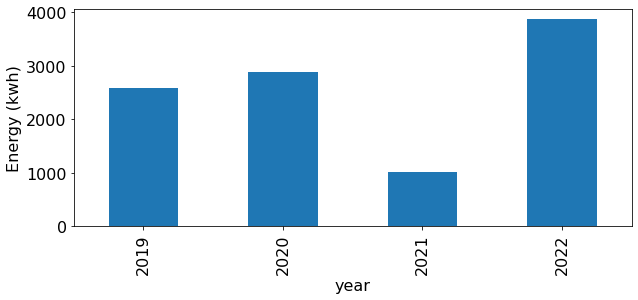

In [317]:
plt.rcParams['figure.figsize']=(10,4)
plt.rcParams['font.size']=16
df.groupby('year').sum()['Energy'].plot.bar()
plt.ylabel("Energy (kwh)")
plt.show()

### CHARGE COUNT BY YEAR

## CHARGED ENERGY BY COUNTRY

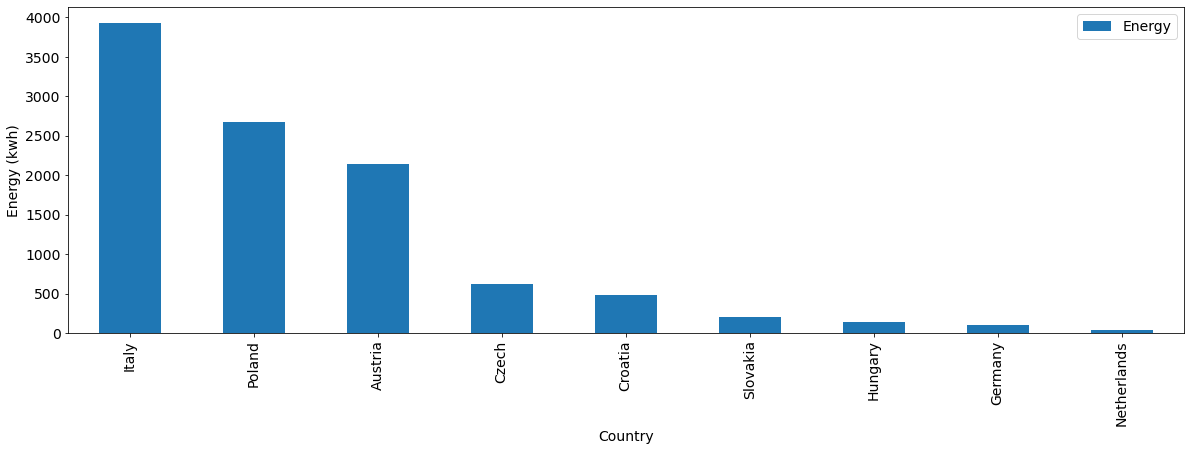

In [316]:
df_energy_country = pd.DataFrame(df.groupby('Country').sum()['Energy']).sort_values(by='Energy', ascending=False)
# fig = plt.Figure(figsize=(20, 20))
plt.rcParams['figure.figsize']=(20,6)
plt.rcParams['font.size']=14
df_energy_country.plot.bar()
plt.ylabel("Energy (kwh)")
plt.show()

In [237]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
%matplotlib inline
from shapely.geometry import Polygon
import warnings
warnings.filterwarnings(action='ignore')

In [238]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

europe=world[world.continent=='Europe']
europe=europe[(europe.name!='Russia') & (europe.name!='Iceland')]
# Create a custom polygon
polygon = Polygon([(-25,35), (40,35), (40,75),(-25,75)])
europe=geopandas.clip(europe, polygon) 

df_country = pd.DataFrame(df.groupby('iso_a3').sum()).reset_index()
df_country

selected_countries=europe[europe.iso_a3.isin(list(df_country.iso_a3))]
selected_countries=selected_countries.merge(df_country, on='iso_a3',how='left')


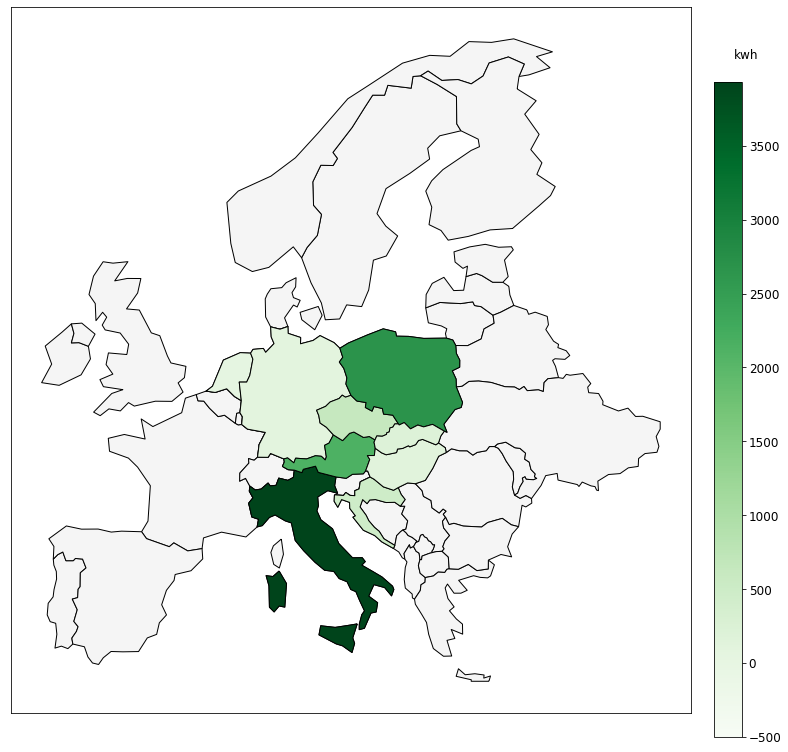

In [239]:
plt.rcParams['figure.figsize']=(13,13)
plt.rcParams['font.size']=12

fig,ax=plt.subplots()

vmin = df_country['Energy'].min()
vmin = -500
vmax = df_country['Energy'].max()

ax = europe.plot(color='whitesmoke',edgecolor='black', ax=ax)
selected_countries.plot('Energy',cmap='Greens', edgecolor='black', ax=ax, vmin=vmin, vmax=vmax)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

# add colorbar
cax = fig.add_axes([0.9, 0.1, 0.03, 0.7]) #[left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable.
sm._A = []
lgd=fig.colorbar(sm, cax=cax).set_label('kwh', rotation=0, y=1.05, labelpad=-35)
plt.show()

## CHARGED ENERGY BY SUPERCHARGER LOCATION  -> CITY

In [240]:
# Import the required library
from geopy.geocoders import Nominatim

# Initialize Nominatim API
geolocator = Nominatim(user_agent="MyApp")

The latitude of the location is:  51.9774364
The longitude of the location is:  23.6538573
Polska


51.9774364

In [242]:
from shapely.geometry import Point
cities = df.City.unique().tolist()
df_cities = pd.DataFrame({
    'City': cities,
    'Coordinates': [Point(list(geolocator.geocode(city)[1])[::-1]) for city in cities]
})

In [276]:
df_cities_energy = df.groupby('City').sum().reset_index()
df_cities_energy = pd.merge(df_cities_energy, df_cities, how='left', on='City')\

gdf = geopandas.GeoDataFrame(df_cities_energy, geometry="Coordinates")

In [245]:

X = gdf["Energy"].to_numpy()
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
max = 100
min = 10
X_scaled = X_std * (max - min) + min
gdf["Energy_scaled"] = X_scaled

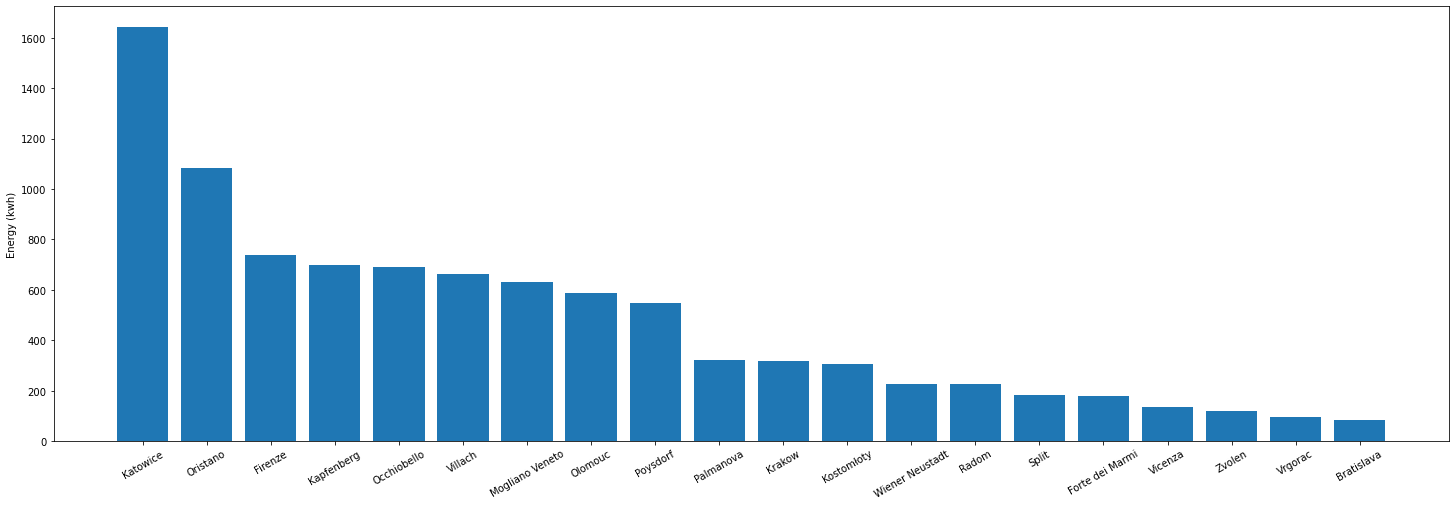

In [315]:
plt.rcParams['figure.figsize']=(25,8)
plt.rcParams['font.size']=10
df_en = df.groupby('City').sum().sort_values('Energy', ascending=False).iloc[:20, :]
plt.bar(x=df_en.index, height=df_en.Energy)
plt.xticks(rotation=30)
plt.ylabel("Energy (kwh)")
plt.show()

In [273]:
import folium 

m = europe.explore(name='countries')

gdf.explore(
     m=m, # pass the map object
     cmap='plasma',
     marker_kwds=dict(radius=10, fill=True, alpha=1), # make marker radius 10px with fill
     column='Energy',  # make choropleth based on "BoroName" column
     tooltip=['Energy', "City"], # show "name" column in the tooltip
     legend=True, # show legend
     tooltip_kwds=dict(labels=True), # do not show column label in the tooltip
     name="cities" # name of the layer in the map
)

folium.TileLayer('Stamen Toner', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control

m  # show map

In [ ]:
'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'